In [114]:
import pandas as pd
import matplotlib.pyplot as plt

chains_2023 = pd.read_csv("../data/chains_data.csv")
chains_2023['x_norm'] = chains_2023['x'] / (chains_2023['venueLength'] / 2)
chains_2023['y_norm'] = chains_2023['y'] / (chains_2023['venueWidth'] / 2) * 0.8
chains_2023 = chains_2023[~chains_2023['playerId'].isnull()]
chains_2023['recipient'] = chains_2023.groupby(['season', 'roundNumber', 'homeTeam.teamName','period'])['playerId'].shift(-1)

player_info = chains_2023[['playerId', 'firstName', 'surname']].drop_duplicates().dropna()
player_info['full_name'] = chains_2023['firstName'] + " " + chains_2023['surname']
player_info.drop(['firstName', 'surname'], axis=1, inplace=True)
# player_info.set_index('playerId', inplace=True)

In [115]:
chains_2023[['description', 'playerId','recipient']]

,description,playerId,recipient
1,Hard Ball Get,CD_I993903,CD_I993903
2,Handball,CD_I993903,CD_I298174
4,Free For,CD_I298174,CD_I298174
5,Kick,CD_I298174,CD_I298174
6,Kick Into F50,CD_I298174,CD_I297255
...,...,...,...
326456,Kick,CD_I294674,CD_I296254
326457,Contested Knock On,CD_I296254,CD_I296254
326458,Contested Knock On,CD_I296254,CD_I1007124
326459,Gather,CD_I1007124,CD_I1007124


In [116]:
df = chains_2023[(chains_2023.roundNumber == 1) & (chains_2023['homeTeam.teamName'] == "Richmond")]

# plt.scatter('x', 'y', c='chain_number', data=df)

In [117]:
pass_network = df[~df.disposal.isnull()][['team','playerId','description', 'disposal', 'shotAtGoal','behindInfo','recipient']]
pass_network = pass_network.merge(player_info, on='playerId', how='inner')
pass_network = pass_network.merge(player_info, left_on='recipient', right_on='playerId', how='inner', suffixes=['_disposer','_reciever'])

pass_network

,team,playerId_disposer,description,disposal,shotAtGoal,behindInfo,recipient,full_name_disposer,playerId_reciever,full_name_reciever
0,Richmond,CD_I993903,Handball,ineffective,NaN,NaN,CD_I298174,Jacob Hopper,CD_I298174,Toby Nankervis
1,Richmond,CD_I298174,Kick,clanger,NaN,NaN,CD_I298174,Toby Nankervis,CD_I298174,Toby Nankervis
2,Carlton,CD_I1004912,Kick,effective,NaN,NaN,CD_I298174,Tom De Koning,CD_I298174,Toby Nankervis
3,Carlton,CD_I990704,Kick,effective,NaN,NaN,CD_I298174,Patrick Cripps,CD_I298174,Toby Nankervis
4,Richmond,CD_I1002245,Kick,effective,NaN,NaN,CD_I298174,Noah Balta,CD_I298174,Toby Nankervis
...,...,...,...,...,...,...,...,...,...,...
683,Richmond,CD_I1006133,Kick,clanger,True,NaN,CD_I1006133,Jack Ross,CD_I1006133,Jack Ross
684,Carlton,CD_I295518,Kick,ineffective,NaN,NaN,CD_I1002259,Sam Docherty,CD_I1002259,Lochie O'Brien
685,Carlton,CD_I1017700,Handball,effective,NaN,NaN,CD_I1002259,Jesse Motlop,CD_I1002259,Lochie O'Brien
686,Carlton,CD_I996731,Handball,effective,NaN,NaN,CD_I1002259,Charlie Curnow,CD_I1002259,Lochie O'Brien


In [109]:
chains_2023.loc[615:625,:]

,season,roundNumber,homeTeam.teamName,awayTeam.teamName,homeTeamScore.totalScore,awayTeamScore.totalScore,date,venue.name,venueWidth,venueLength,...,position,description,disposal,shotAtGoal,behindInfo,x,y,x_norm,y_norm,recipient
615,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,KEY_DEFENDER,Contested Mark,NaN,NaN,NaN,-32,46,-0.4000,0.521986,CD_I993832
616,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,KEY_DEFENDER,Contested Mark,NaN,NaN,NaN,32,-46,0.4000,-0.521986,CD_I993832
617,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,KEY_DEFENDER,Kick,ineffective,NaN,NaN,22,-46,0.2750,-0.521986,CD_I1000953
619,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,KEY_FORWARD,Kick Inside 50 Result,NaN,NaN,NaN,59,-21,0.7375,-0.238298,CD_I1002245
620,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,KEY_DEFENDER,Loose Ball Get,NaN,NaN,NaN,63,-20,0.7875,-0.226950,CD_I1002245
621,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,KEY_DEFENDER,Loose Ball Get,NaN,NaN,NaN,-63,20,-0.7875,0.226950,CD_I1002245
622,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,KEY_DEFENDER,Kick,effective,NaN,NaN,-66,27,-0.8250,0.306383,NaN
623,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,NaN,Out of Bounds,NaN,NaN,NaN,-28,65,-0.3500,0.737589,CD_I298174
624,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,RUCK,Loose Ball Get,NaN,NaN,NaN,-20,51,-0.2500,0.578723,CD_I298174
625,2023,1,Richmond,Carlton,58,58,2023-03-16,MCG,141,160,...,RUCK,Handball,effective,NaN,NaN,-17,49,-0.2125,0.556028,CD_I270896


In [29]:
disposal_types = chains_2023[~chains_2023.disposal.isnull()].description.unique()
disposal_types

array(['Handball', 'Kick', 'Ground Kick'], dtype=object)

<Axes: >

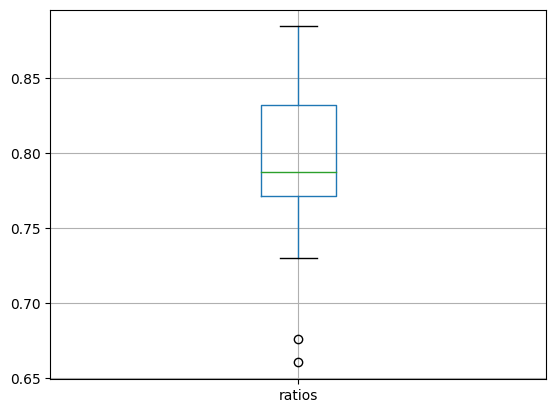

In [25]:
venues = chains_2023[['venue.name', 'venueWidth', 'venueLength']].drop_duplicates().reset_index()

venues['ratios'] = venues.venueWidth / venues.venueLength

venues.boxplot(column=['ratios'])